In [1]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d deadskull7/fer2013


 92% 89.0M/96.6M [00:02<00:00, 32.7MB/s]
100% 96.6M/96.6M [00:02<00:00, 41.0MB/s]


In [ ]:
import zipfile
from tqdm import tqdm

In [ ]:
zf = zipfile.ZipFile('fer2013.zip')
uncompress_size = sum((file.file_size for file in zf.infolist()))
extracted_size = 0
for file in tqdm(zf.infolist()):
    extracted_size += file.file_size
    zf.extract(file)

100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


In [ ]:
ls

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

Using TensorFlow backend.


In [ ]:
dataset_path = '/content/fer2013.csv'
image_size=(48,48)
# parameters
batch_size = 32
num_epochs = 200
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
#base_path = 'models/'
l2_regularization=0.01


In [ ]:

def load_fer2013():
	data = pd.read_csv(dataset_path)
	pixels = data['pixels'].tolist()
	width, height = 48, 48
	faces = []
	for pixel_sequence in tqdm(pixels):
		face = [int(pixel) for pixel in pixel_sequence.split(' ')]
		face = np.asarray(face).reshape(width, height)
		face = cv2.resize(face.astype('uint8'),image_size)
		faces.append(face.astype('float32'))
	faces = np.asarray(faces)
	faces = np.expand_dims(faces, -1)
	emotions = pd.get_dummies(data['emotion']).to_numpy()
 #.as_matrix()
	return faces, emotions

#df['Price']




In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


In [ ]:
regularization = l2(l2_regularization)

# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
from tensorflow import keras

keras.utils.plot_model(model, "my_first_model.png")

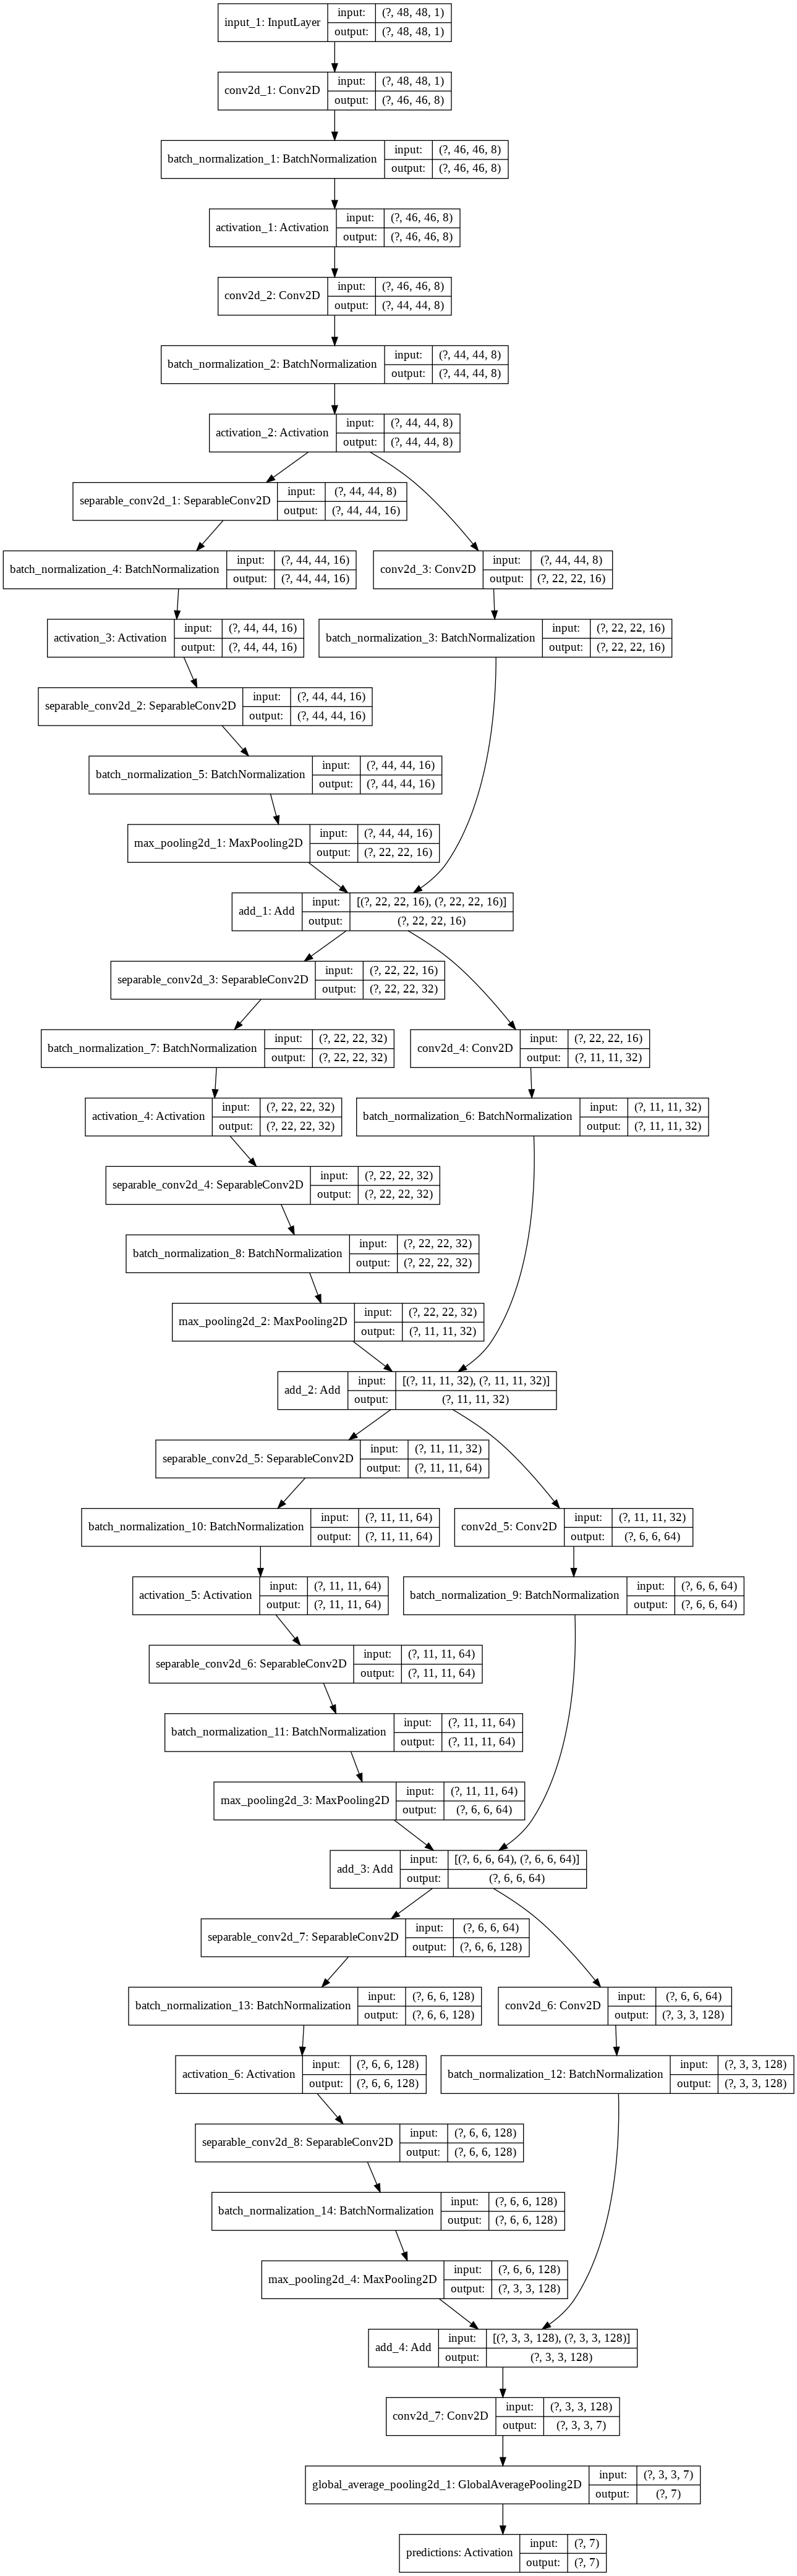

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:

# loading dataset
faces, emotions = load_fer2013()



100%|██████████| 35887/35887 [00:23<00:00, 1552.30it/s]


In [ ]:
faces = preprocess_input(faces)

In [ ]:
num_samples, num_classes = emotions.shape

In [ ]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [ ]:
history =model.fit_generator(data_generator.flow(xtrain, ytrain,
                                            batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1,
                        validation_data=(xtest,ytest))
model.save("my_Model.h5")
model.save("my_Model.hdf5")


Epoch 1/200
898/897 [==============================] - 52s 58ms/step - loss: 1.7753 - accuracy: 0.3275 - val_loss: 1.8077 - val_accuracy: 0.3541
Epoch 2/200
898/897 [==============================] - 41s 46ms/step - loss: 1.4909 - accuracy: 0.4450 - val_loss: 1.5634 - val_accuracy: 0.4184
Epoch 3/200
898/897 [==============================] - 41s 46ms/step - loss: 1.3726 - accuracy: 0.4880 - val_loss: 1.3135 - val_accuracy: 0.5109
Epoch 4/200
898/897 [==============================] - 41s 46ms/step - loss: 1.3023 - accuracy: 0.5125 - val_loss: 1.3488 - val_accuracy: 0.5043
Epoch 5/200
898/897 [==============================] - 41s 46ms/step - loss: 1.2572 - accuracy: 0.5311 - val_loss: 1.3077 - val_accuracy: 0.5181
Epoch 6/200
898/897 [==============================] - 41s 45ms/step - loss: 1.2264 - accuracy: 0.5447 - val_loss: 1.2518 - val_accuracy: 0.5364
Epoch 7/200
898/897 [==============================] - 40s 45ms/step - loss: 1.2012 - accuracy: 0.5491 - val_loss: 1.2384 - val_ac

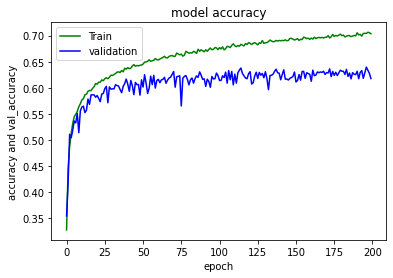

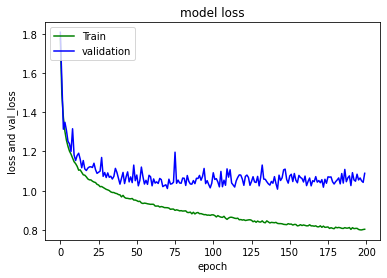

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['accuracy'],color='green')
plt.plot(history['val_accuracy'],color='blue')
plt.title('model accuracy')

plt.ylabel('accuracy and val_accuracy')
plt.xlabel('epoch')
plt.legend(['Train','validation'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history['loss'],color='green')
plt.plot(history['val_loss'],color='blue')
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss and val_loss')
plt.xlabel('epoch')
plt.legend(['Train','validation'], loc='upper left')
plt.show()

In [ ]:
np.save('my_history.npy',history.history)


In [ ]:
history=x

In [ ]:
x=np.load('my_history.npy',allow_pickle='TRUE').item()

In [ ]:
x

{'accuracy': [0.32752794,
  0.4449824,
  0.48800027,
  0.5125222,
  0.5310878,
  0.5446724,
  0.5490613,
  0.55466926,
  0.56362116,
  0.5693337,
  0.57675296,
  0.57912153,
  0.5867498,
  0.5875161,
  0.5933331,
  0.59490055,
  0.5945522,
  0.5989063,
  0.60221535,
  0.6082065,
  0.60695255,
  0.61085373,
  0.61064476,
  0.61506844,
  0.6136055,
  0.6174719,
  0.61921346,
  0.6173674,
  0.62015396,
  0.6241248,
  0.62360233,
  0.6255878,
  0.6273642,
  0.6300115,
  0.6304643,
  0.62931484,
  0.6332161,
  0.6305688,
  0.63750046,
  0.63568914,
  0.63868475,
  0.63652515,
  0.63770944,
  0.64175,
  0.64450175,
  0.64140165,
  0.64279497,
  0.6420983,
  0.64303875,
  0.6437006,
  0.64551187,
  0.6490996,
  0.6496569,
  0.6507019,
  0.65355814,
  0.65080637,
  0.651712,
  0.652757,
  0.65610087,
  0.6539761,
  0.6533491,
  0.6551604,
  0.6566582,
  0.65826046,
  0.66035044,
  0.6574942,
  0.65735483,
  0.6602111,
  0.6613257,
  0.6618134,
  0.66038525,
  0.66048974,
  0.6665506,
  0.66494

In [ ]:
print("ahemd_ali")

ahemd_ali


In [ ]:
print("youssef")

youssef


In [ ]:
print("ahmed_ali")

ahmed_ali


In [ ]:
print("ahmed_ali_ahmed")

ahmed_ali_ahmed
